### Code for generating artificial data for the CCP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from lib.problems.generator import ProblemDataset, Generator

sns.set()

pytorch version: 1.11.0 
pytorch CUDA version: 11.3 
pytorch CUDA available: True 
--------------------------------------- 




In [3]:
VAL = False
VSIZE = 128     # size of validation dataset
TSIZE = 100 #256     # size of test dataset
K = (3, 12)
N = 200         # number of nodes
VSEED = 1234
TSEED = 4321 #234
MAX_CAP = 1.1   # [1.05, 1.1, 1.2, 1.5]
COORDS_DIST = "gm"      # [gm, mixed]
UNF_FRAC = 0.2  # fraction of uniformly sampled coords for mixed data

k = K
if isinstance(K, tuple):
    k = f"{K[0]}-{K[1]}"
    K = (K[0], K[1]+1)  # second value is exclusive in generator!
dist = COORDS_DIST if COORDS_DIST == "gm" else f"{COORDS_DIST}_unf{UNF_FRAC}"

save_pth = f"./data/CCP/CCP{N}/"
v_fname = f"val_{dist}_n{N}_k{k}_s{VSIZE}_cap{str(MAX_CAP).replace('.', '_')}_seed{VSEED}"
t_fname = f"test_{dist}_n{N}_k{k}_s{TSIZE}_cap{str(MAX_CAP).replace('.', '_')}_seed{TSEED}"

In [4]:
ds = ProblemDataset(
    problem="CCP",
    seed=VSEED,
    coords_sampling_dist=COORDS_DIST,
    weights_sampling_dist="uniform",
    max_cap_factor=MAX_CAP,
    n_components=K,
    uniform_fraction=UNF_FRAC,
)
ds.seed(VSEED)

CCPInstance( coords=ndarray_[200, 2],  demands=ndarray_[200],  graph_size=200,  constraint_value=1.0,  num_components=4)
CCPInstance( coords=ndarray_[200, 2],  demands=ndarray_[200],  graph_size=200,  constraint_value=1.0,  num_components=9)
CCPInstance( coords=ndarray_[200, 2],  demands=ndarray_[200],  graph_size=200,  constraint_value=1.0,  num_components=9)
CCPInstance( coords=ndarray_[200, 2],  demands=ndarray_[200],  graph_size=200,  constraint_value=1.0,  num_components=8)
CCPInstance( coords=ndarray_[200, 2],  demands=ndarray_[200],  graph_size=200,  constraint_value=1.0,  num_components=10)


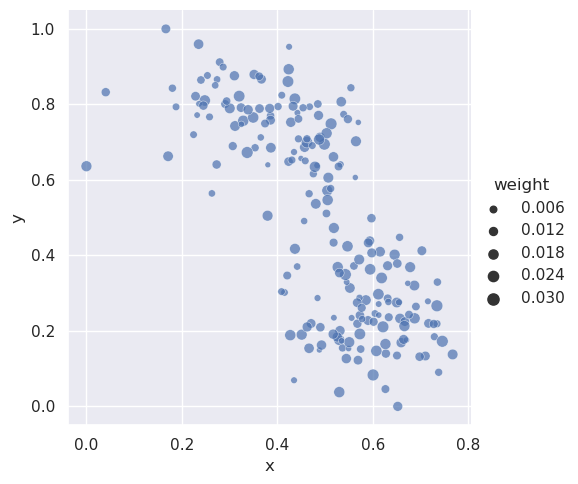

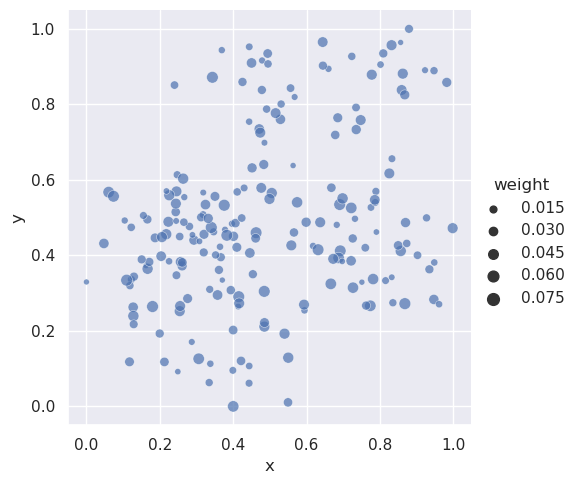

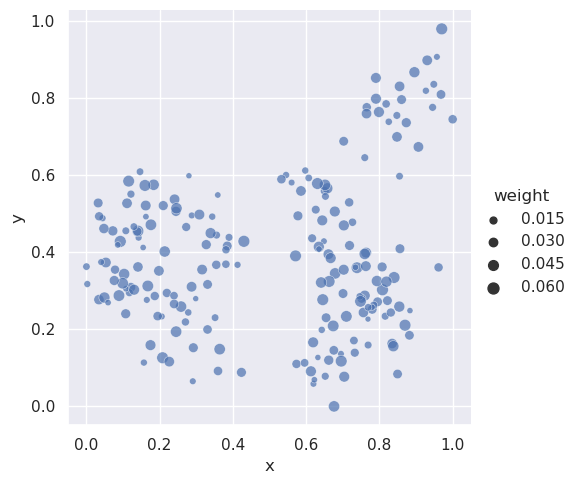

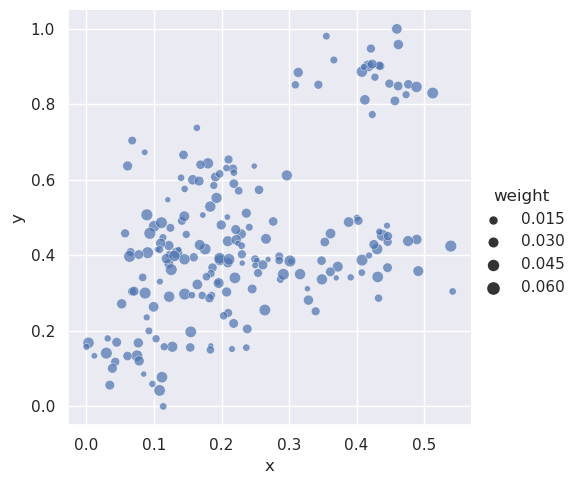

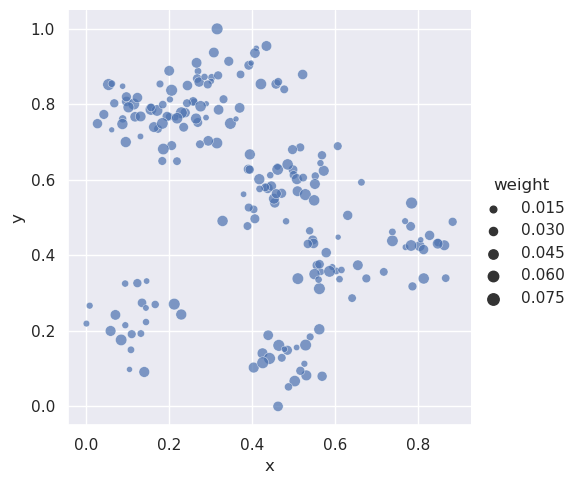

In [6]:
data = ds.sample(sample_size=5, graph_size=N).data
for d in data:
    print(d)
    dat = np.concatenate([d.coords, d.demands[:, None]], axis=-1)

    dat = pd.DataFrame(dat, columns=["x", "y", "weight"])
    #dat.label = dat.label.astype('int')
    sns.relplot(
        x="x", y="y",
        #hue="label",
        size="weight",
        palette=sns.color_palette("Spectral", as_cmap=True), alpha=0.7,
        data=dat
    )


In [5]:
if VAL:
    SIZE = VSIZE
    SEED = VSEED
    fname = v_fname
else:
    SIZE = TSIZE
    SEED = TSEED
    fname = t_fname
os.makedirs(save_pth, exist_ok=True)

In [6]:
ds = ProblemDataset(
    problem="CCP",
    seed=SEED,
    coords_sampling_dist=COORDS_DIST,
    weights_sampling_dist="uniform",
    max_cap_factor=MAX_CAP,
    n_components=K,
    uniform_fraction=UNF_FRAC,
)
ds.seed(SEED)
data = ds.sample(sample_size=SIZE, graph_size=N).data

In [86]:
# create batch instance id for DF
bid = np.repeat(np.arange(SIZE), N).reshape(SIZE, N)
bid

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [253, 253, 253, ..., 253, 253, 253],
       [254, 254, 254, ..., 254, 254, 254],
       [255, 255, 255, ..., 255, 255, 255]])

In [87]:
frames = []
for i, d in zip(bid, data):
    dat = np.concatenate([i[:, None], d.coords, d.demands[:, None]], axis=-1)
    frames.append(pd.DataFrame(dat, columns=["batch_id", "x_coord", "y_coord", "weight"]))

df = pd.concat(frames)
df = df.astype({'batch_id': 'int32'})

In [88]:
df.describe()

,batch_id,x_coord,y_coord,weight
count,12800.000000,12800.000000,12800.000000,12800.000000
mean,127.500000,0.434069,0.442518,0.102038
std,73.903158,0.265644,0.270659,0.066942
min,0.000000,0.000000,0.000000,0.005923
25%,63.750000,0.210598,0.214025,0.048289
50%,127.500000,0.407554,0.418613,0.086536
75%,191.250000,0.642064,0.650207,0.144331
max,255.000000,1.000000,1.000000,0.362087


In [89]:
# save as csv
pth = os.path.join(save_pth, fname + ".csv")
df.to_csv(pth, index=False)

In [7]:
# save as npz
pth = os.path.join(save_pth, fname + ".npz")
Generator.save_dataset(data, filepath=pth)

'data/CCP/CCP200/test_gm_n200_k3-12_s100_cap1_1_seed4321.npz'

### create data from telecom datasets by subsampling

In [3]:
from copy import deepcopy
import torch
from lib.problems import sub_sample
from lib.utils import CCPInstance

In [7]:
DSET = "telecom_italia" # "shanghai_telecom" #
CAP = 1.1
DATA_PTH = f"data/CCP/benchmark/{DSET}/data_norm_cap{CAP}_.dat"
COLS = ["num_users", "x_coord", "y_coord", "normalized_workload"]
PARTITION = "test" #"train"

SAMPLING_METHOD = "quadrant_rnd"
P_SIZE = 100 #512   # size of part
N_PARTS = 1 #10
SIZE = N_PARTS*P_SIZE

SEED = 4321 #1234
N = 500
if "italia" in DSET:
    WF = (2.0, 5.0)
    FULL_K = 25
else:
    WF = (1.5, 4.0)
    FULL_K = 40
MAX_W = 0.2

sd = "" if PARTITION == "test" else "raw/"
save_pth = f"./data/CCP/benchmark/{DSET}/sub/{sd}"
fname = f"{PARTITION}_n{N}_s{SIZE}_cap{str(CAP).replace('.', '_')}_seed{SEED}"

assert SIZE % N_PARTS == 0
part_size = SIZE//N_PARTS
os.makedirs(save_pth, exist_ok=True)

In [8]:
data = torch.load(DATA_PTH)
print(len(data))
xyw = data[:, 1:]
rng = np.random.RandomState(SEED)


2020


In [9]:
n = len(xyw)
full_pth = f"./data/CCP/benchmark/{DSET}/full_test_n{n}_k{FULL_K}_cap{str(CAP).replace('.', '_')}.npz"
inst = CCPInstance(
coords=xyw[:, :2],
demands=xyw[:, -1],
graph_size=n,
constraint_value=1.0,
num_components=FULL_K,
)
Generator.save_dataset([inst], filepath=full_pth, problem="ccp")

'data/CCP/benchmark/telecom_italia/full_test_n2020_k25_cap1_1.npz'

In [23]:
for i in range(N_PARTS):
    samples = sub_sample(deepcopy(xyw), size=P_SIZE, n=N, rng=rng,
                         method=SAMPLING_METHOD, weight_factor=WF, max_weight=MAX_W)
    # convert to CCPInstances
    instances = [
        CCPInstance(
            coords=s[:, :2],
            demands=s[:, -1],
            graph_size=N,
            constraint_value=1.0,
            )
        for s in samples
    ]
    prt = f"_part{i}" if N_PARTS > 1 else ""
    pth = os.path.join(save_pth, fname + f"{prt}.npz")
    Generator.save_dataset(instances, filepath=pth)

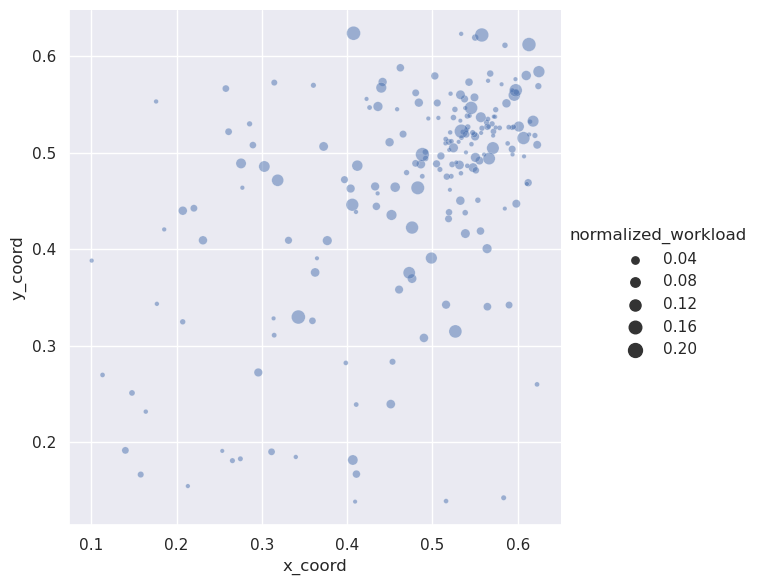

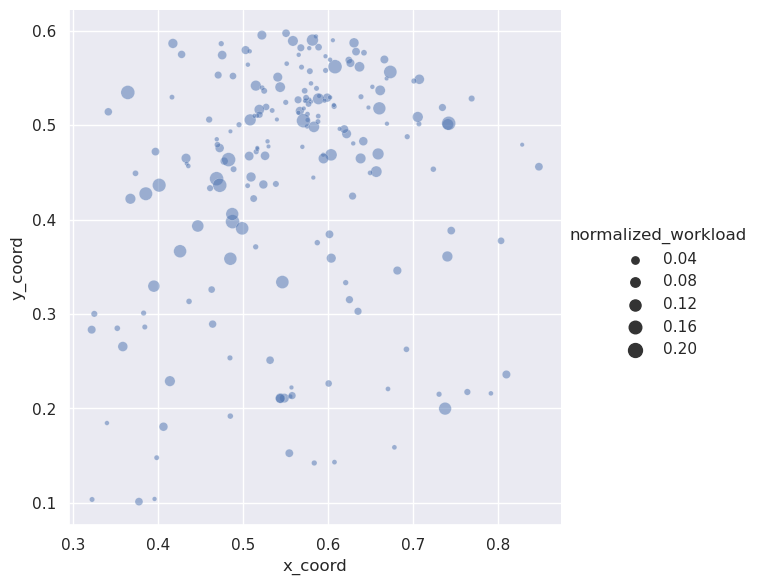

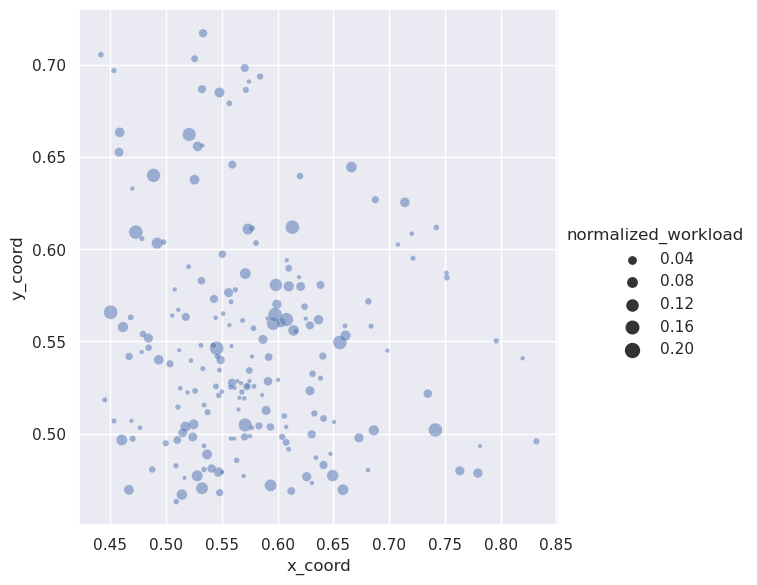

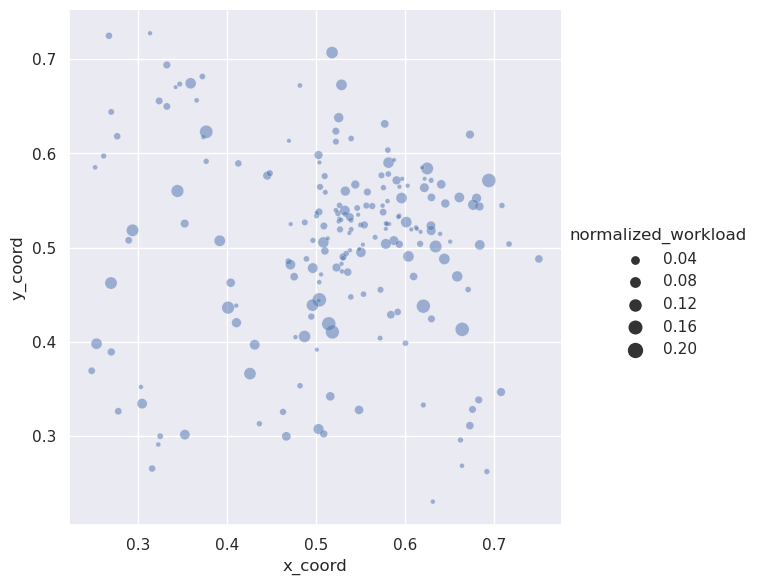

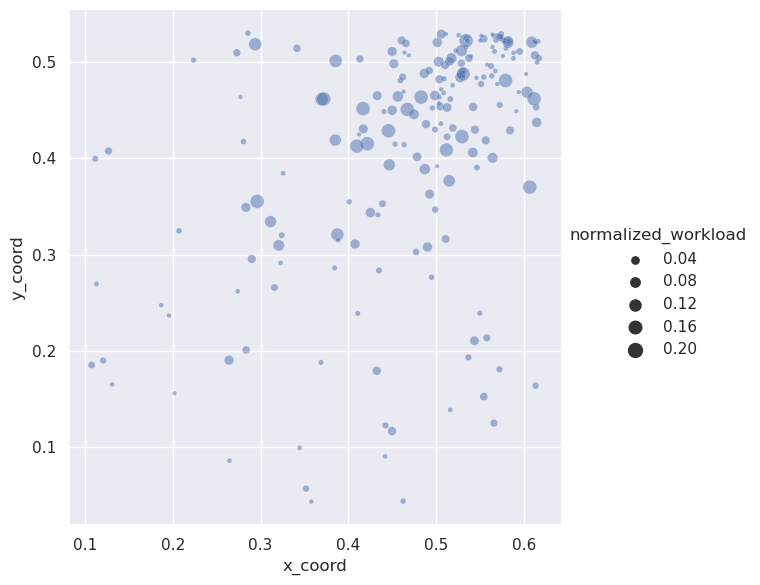

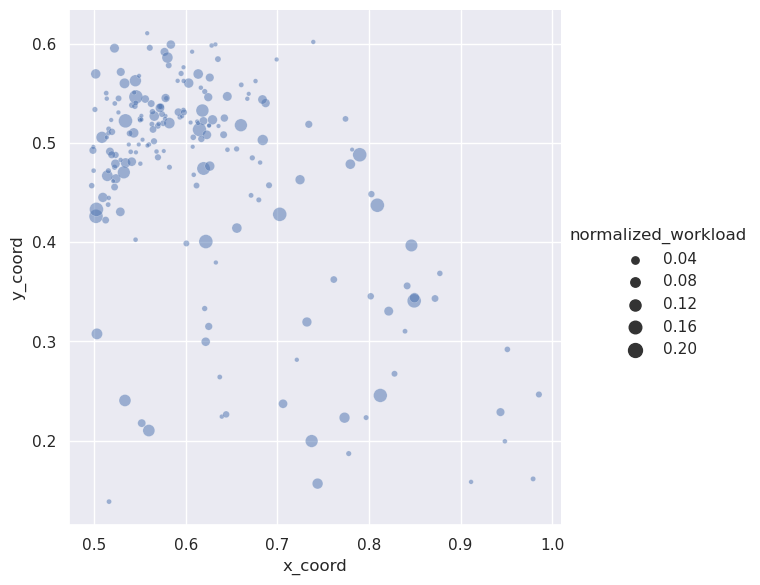

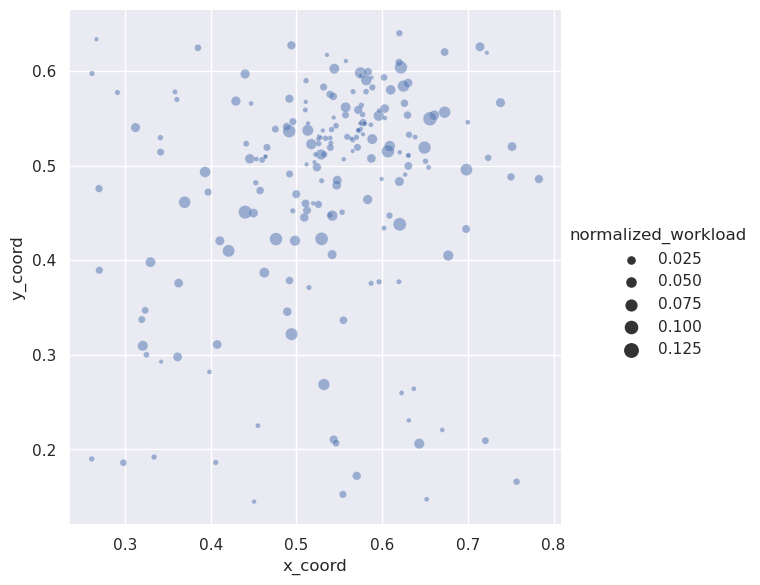

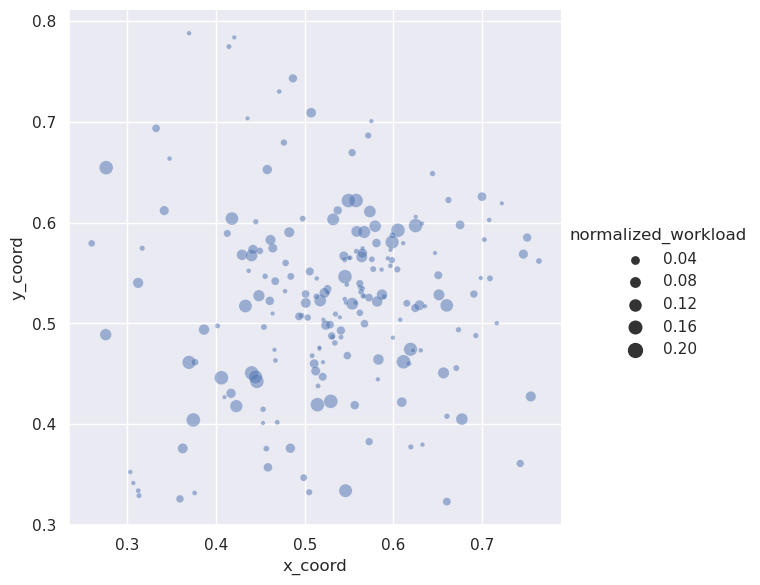

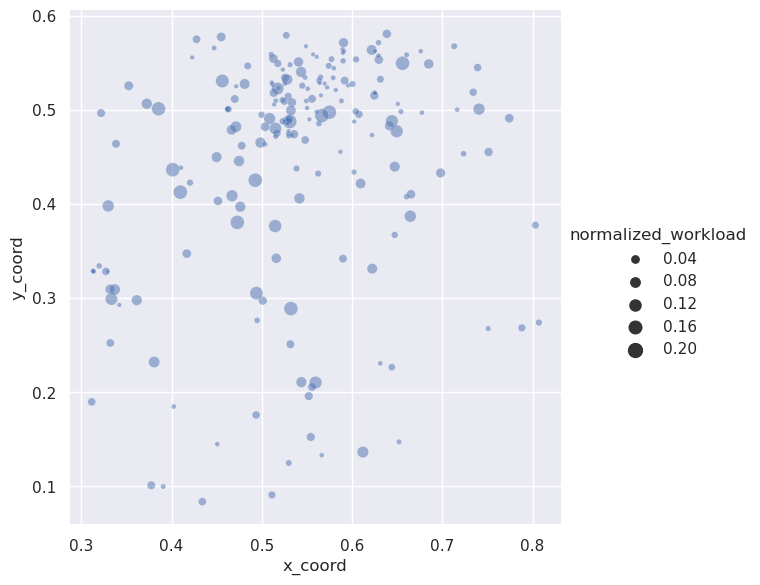

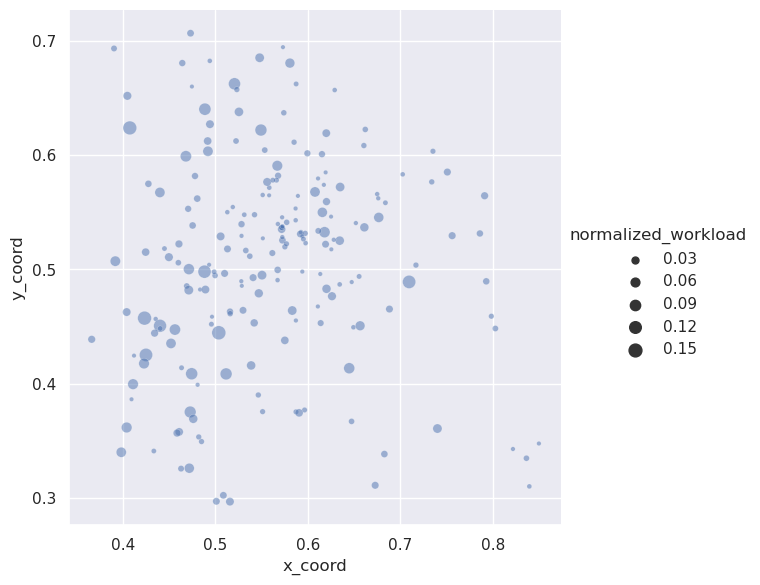

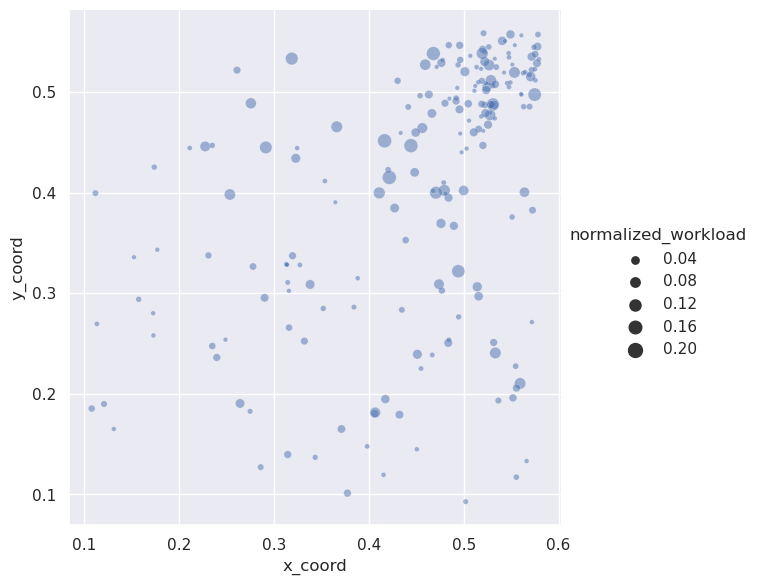

In [11]:
i = 0
for smp in samples:
    df_ = pd.DataFrame(data=smp, columns=COLS[1:])
    sns.relplot(x="x_coord", y="y_coord", size="normalized_workload",
                sizes=(10, 100), alpha=.5, palette="muted",
                height=6, data=df_)
    i += 1
    if i > 10:
        break